In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
# Rutas completas
TRAIN_PATH = r"C:\Users\USUARIO\Desktop\ModelosML\archivos\train"
TEST_PATH = r"C:\Users\USUARIO\Desktop\ModelosML\archivos\test"
BASE_PATH = r"C:\Users\USUARIO\Desktop\ModelosML\archivos\archive"

In [ ]:
# Definir las dimensiones de las imágenes (48x48, 1 canal para escala de grises)
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 32
CHANNELS = 1  # Escala de grises

In [ ]:
# Definir las clases (emociones en inglés)
CLASSES = ['surprise', 'happy', 'neutral', 'angry', 'fear', 'sad', 'disgust']

In [ ]:
# Crear generadores de datos con aumentación (mismo nivel que el modelo original)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
# Generador para el conjunto de entrenamiento
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='training',
    shuffle=True
)

Found 22968 images belonging to 7 classes.


In [ ]:
# Generador para el conjunto de validación
validation_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='validation',
    shuffle=False
)

Found 5741 images belonging to 7 classes.


In [ ]:
# Generador para el conjunto de prueba (sin aumentación)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [ ]:
# Obtener el número de clases y el mapeo de clases
num_classes = len(CLASSES)
class_indices = train_generator.class_indices
print("Número de clases:", num_classes)
print("Clases:", class_indices)

Número de clases: 7
Clases: {'surprise': 0, 'happy': 1, 'neutral': 2, 'angry': 3, 'fear': 4, 'sad': 5, 'disgust': 6}


In [ ]:
# Definir pesos de clase manualmente
class_weights_dict = {
    class_indices['surprise']: 2.3,  # 3171 imágenes
    class_indices['happy']: 1.0,    # 7215 imágenes
    class_indices['neutral']: 1.5,  # 4930 imágenes
    class_indices['angry']: 1.8,    # 3995 imágenes
    class_indices['fear']: 1.8,     # 4095 imágenes
    class_indices['sad']: 1.5,      # 4953 imágenes
    class_indices['disgust']: 10.0  # 436 imágenes
}
print("Pesos de clase:", class_weights_dict)

Pesos de clase: {0: 2.3, 1: 1.0, 2: 1.5, 3: 1.8, 4: 1.8, 5: 1.5, 6: 10.0}


In [ ]:
# Construir la arquitectura Mini-Xception original
def mini_xception(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Primer bloque
    x = Conv2D(8, (3, 3), padding='same', strides=(1, 1), use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), padding='same', strides=(1, 1), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Primer módulo residual
    residual = Conv2D(16, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    residual = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(residual)

    x = SeparableConv2D(16, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    # Segundo módulo residual
    residual = Conv2D(32, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    residual = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(residual)

    x = SeparableConv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    # Tercer módulo residual
    residual = Conv2D(64, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    residual = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(residual)

    x = SeparableConv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    # Capa final
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
# Crear el modelo Mini-Xception
model = mini_xception(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), num_classes=num_classes)

In [ ]:
# Compilar el modelo con Categorical Crossentropy
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 8)    72          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 48, 48, 8)    0           ['batch_normalization[0][0]']

In [ ]:
# Callbacks para entrenamiento
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(BASE_PATH, 'best_mini_xception_manual_weights_48x48.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

In [ ]:
# Entrenar el modelo
steps_per_epoch = train_generator.n // BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/50
717/717 [==============================] - 872s 1s/step - loss: 3.2640 - accuracy: 0.1824 - val_loss: 1.9119 - val_accuracy: 0.1617 - lr: 0.0010
Epoch 2/50
717/717 [==============================] - 845s 1s/step - loss: 3.1726 - accuracy: 0.2178 - val_loss: 1.8461 - val_accuracy: 0.1887 - lr: 0.0010
Epoch 3/50
717/717 [==============================] - 839s 1s/step - loss: 3.1116 - accuracy: 0.2361 - val_loss: 1.8289 - val_accuracy: 0.2226 - lr: 0.0010
Epoch 4/50
717/717 [==============================] - 838s 1s/step - loss: 3.0873 - accuracy: 0.2480 - val_loss: 1.8591 - val_accuracy: 0.1905 - lr: 0.0010
Epoch 5/50
717/717 [==============================] - 851s 1s/step - loss: 3.0628 - accuracy: 0.2621 - val_loss: 1.7788 - val_accuracy: 0.2874 - lr: 0.0010
Epoch 6/50
717/717 [==============================] - 870s 1s/step - loss: 3.0391 - accuracy: 0.2690 - val_loss: 1.8089 - val_accuracy: 0.2591 - lr: 0.0010
Epoch 7/50
717/717 [==============================] - 838s 1s/st

In [ ]:
# Cargar el mejor modelo guardado
model.load_weights(os.path.join(BASE_PATH, 'best_mini_xception_manual_weights_48x48.h5'))

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

225/225 [==============================] - 7s 31ms/step - loss: 1.2913 - accuracy: 0.5057
Test Loss: 1.2913
Test Accuracy: 0.5057


In [ ]:
# Obtener predicciones y etiquetas reales
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

225/225 [==============================] - 4s 16ms/step


In [ ]:
# Calcular métricas con Scikit-learn
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

Classification Report:
              precision    recall  f1-score   support

    surprise       0.57      0.78      0.66       831
       happy       0.71      0.79      0.75      1774
     neutral       0.42      0.69      0.52      1233
       angry       0.36      0.27      0.31       958
        fear       0.31      0.05      0.09      1024
         sad       0.44      0.30      0.36      1247
     disgust       0.17      0.44      0.24       111

    accuracy                           0.51      7178
   macro avg       0.42      0.47      0.42      7178
weighted avg       0.48      0.51      0.47      7178



In [ ]:
# Calcular F1-score promedio
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"Weighted F1-Score: {f1:.4f}")

Weighted F1-Score: 0.4691


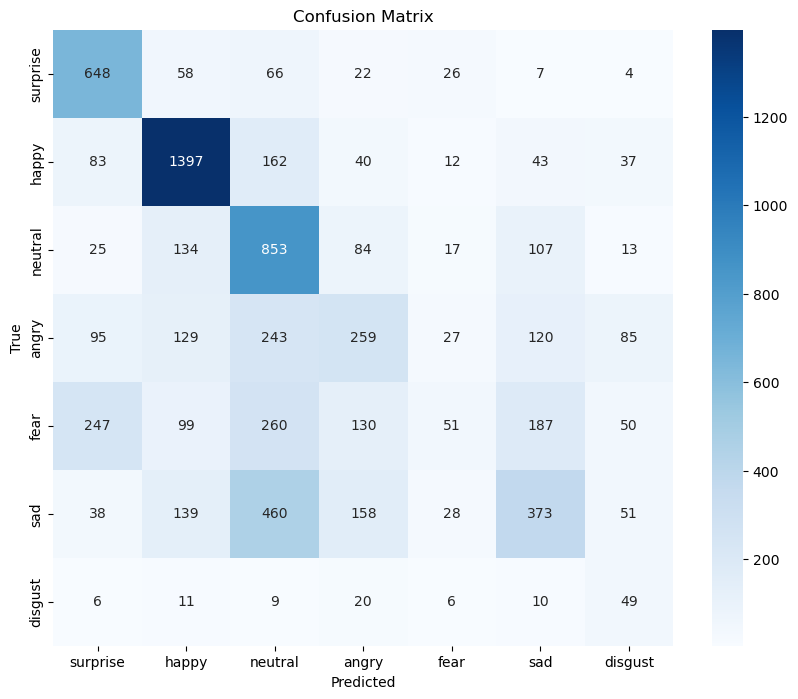

In [ ]:
# Crear y mostrar la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Análisis de la matriz de confusión
print("Análisis de la matriz de confusión:")
for i, emotion in enumerate(CLASSES):
    true_positives = cm[i, i]
    false_positives = sum(cm[:, i]) - true_positives
    false_negatives = sum(cm[i, :]) - true_positives
    print(f"\n{emotion}:")
    print(f"  Verdaderos positivos: {true_positives}")
    print(f"  Falsos positivos: {false_positives}")
    print(f"  Falsos negativos: {false_negatives}")
    # Identificar clases con las que se confunde
    confusions = [(CLASSES[j], cm[i, j]) for j in range(len(CLASSES)) if j != i and cm[i, j] > 0]
    if confusions:
        print("  Se confunde con:")
        for conf_emotion, count in confusions:
            print(f"    - {conf_emotion}: {count} veces")

Análisis de la matriz de confusión:

surprise:
  Verdaderos positivos: 648
  Falsos positivos: 494
  Falsos negativos: 183
  Se confunde con:
    - happy: 58 veces
    - neutral: 66 veces
    - angry: 22 veces
    - fear: 26 veces
    - sad: 7 veces
    - disgust: 4 veces

happy:
  Verdaderos positivos: 1397
  Falsos positivos: 570
  Falsos negativos: 377
  Se confunde con:
    - surprise: 83 veces
    - neutral: 162 veces
    - angry: 40 veces
    - fear: 12 veces
    - sad: 43 veces
    - disgust: 37 veces

neutral:
  Verdaderos positivos: 853
  Falsos positivos: 1200
  Falsos negativos: 380
  Se confunde con:
    - surprise: 25 veces
    - happy: 134 veces
    - angry: 84 veces
    - fear: 17 veces
    - sad: 107 veces
    - disgust: 13 veces

angry:
  Verdaderos positivos: 259
  Falsos positivos: 454
  Falsos negativos: 699
  Se confunde con:
    - surprise: 95 veces
    - happy: 129 veces
    - neutral: 243 veces
    - fear: 27 veces
    - sad: 120 veces
    - disgust: 85 veces

f